# Construction d'un système de recommandation

Nous avons décidé d'orienter notre projet sur la recommendation de films.
En effet durant ce confinement, nous avons eu le temps de visionner beaucoup de films,
mais nous nous sommes rendus compte que nous passions quasiment autant de temps
à choisir le film qu'à le regarder. D'où la nécessité de créer un système de re-
commendations afin d'optimiser notre temps de visionnage.
Nous avons chercher une base de données assez exploitable afin de mener à bien
notre projet. Nous nous sommes basés sur la base de données de 'The Movies Dataset'.

# Différents systèmes de recommandation

- [x] popularity based = moyenne simple
- [x] memory-based (user- et item- based)
- [x] hybride : popularity/collabo
- [x] clustering
- [ ] hybride : cluster/collabo
- [ ] model-based (matrix factorisation, optimisation avec descente de gradient)
    - [x] descente de gradient
    - [ ] cross-validation pour tuner les hyperparamètres
- [ ] hybride : cluster/model
- [ ] user-centered linear approach = descente de gradient (même pb d'opti que model-based, mais on donne les infos des films)


In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re
from time import time
from ast import literal_eval

In [2]:
%load_ext line_profiler

## Fetching and cleaning data

Nous utilisons deux tables de données. L'une, *movies_metadata.csv*, contient une liste de films et des informations relativesau genre, date de sortie etc. 

In [3]:
movies = pd.read_csv("movies_metadata.csv")
ratings = pd.read_csv("ratings_small.csv")
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
link = pd.read_csv("links_small.csv")

C:\Users\VICTOR\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [6]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
def filter_correct_id(word):
    if not isinstance(word, str) or re.fullmatch(r'[0-9]+', word):
        return word
    return "wrong_id"

In [5]:
movies = movies[~movies.id.duplicated()]
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')

### Avis des utilisateurs

In [6]:
ratings = pd.read_csv("ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
# ne pas re-run !
ratings = ratings.drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [11]:
ratings[(ratings['userId'] == 1) & (ratings['movieId'] == 31)]

,userId,movieId,rating
0,1,31,2.5


In [12]:
print(min(ratings.rating), max(ratings.rating))
ratings.describe()
ratings.dtypes

0.5 5.0


userId       int64
movieId      int64
rating     float64
dtype: object

Dans tout le notebook, on considère l'existence d'une variable globale `dfr` contenant la dataframe des notes et `dfm` contenant la dataframe des films. Cela nous permet d'abord tester notre code sur des petits échantillons et avant de les faire tourner sur la totalité des donneés, sans avoir à modifier le code. De même,

## Top films par genres

### Selection des genres

In [13]:
dfr = ratings.copy()
dfm = movies.copy().rename(columns={'id' : 'movieId'})
dfm = dfm.merge(dfr, how='inner')
dfm = dfm.loc[:, ['movieId', 'genres', 'title']]
dfm.head()
# dfm.sort_values(by='movieId').head(100)
# dfr.head(20)

,movieId,genres,title
0,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
1,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
2,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
3,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat
4,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Heat


In [14]:
def simplify_genre(l):
    if len(l) <= 0 :
        return []
    if isinstance(l[0], dict):
        return [d['name'] for d in l]
    return l

In [15]:
dfm['genres'] = dfm['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x).apply(simplify_genre)
dfm.head()

,movieId,genres,title
0,949,"[Action, Crime, Drama, Thriller]",Heat
1,949,"[Action, Crime, Drama, Thriller]",Heat
2,949,"[Action, Crime, Drama, Thriller]",Heat
3,949,"[Action, Crime, Drama, Thriller]",Heat
4,949,"[Action, Crime, Drama, Thriller]",Heat


### Normaliser les notes sur toutes les données

In [16]:
%timeit dfm['mean_rating'] = ratings.groupby('movieId').mean().loc[:, ['rating']]

8.57 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
dfm.head()

,movieId,genres,title,mean_rating
0,949,"[Action, Crime, Drama, Thriller]",Heat,NaN
1,949,"[Action, Crime, Drama, Thriller]",Heat,3.872470
2,949,"[Action, Crime, Drama, Thriller]",Heat,3.401869
3,949,"[Action, Crime, Drama, Thriller]",Heat,3.161017
4,949,"[Action, Crime, Drama, Thriller]",Heat,2.384615


In [18]:
dfm = dfm.sort_values(by='mean_rating', ascending=False)

In [19]:
dfm.head()

,movieId,genres,title,mean_rating
702,1945,"[Drama, Thriller]",Nell,5.0
4711,1092,"[Thriller, Mystery]",The Third Man,5.0
32515,920,"[Animation, Adventure, Comedy, Family]",Cars,5.0
3202,3083,"[Comedy, Drama]",Mr. Smith Goes to Washington,5.0
32460,588,"[Horror, Mystery]",Silent Hill,5.0


# <span style="color:green">copy de dfm + join pour que mean_rating soit respecté + ou ne pas faire de repetition et utiliser deux tables ? </span>

In [20]:
# 1 genre par ligne
serie = dfm.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
serie.name = 'genres'
dfm_simpl = dfm.copy().drop('genres', axis=1).join(serie)
dfm_simpl.head()

,movieId,title,mean_rating,genres
0,949,Heat,NaN,Action
0,949,Heat,NaN,Crime
0,949,Heat,NaN,Drama
0,949,Heat,NaN,Thriller
1,949,Heat,3.87247,Action


In [21]:
def top(genres):
    # selection des films par genre
    df_genres = dfm_simpl.loc[dfm_simpl['genres'].isin(genres)]
    df_genres = df_genres.sort_values(by='mean_rating', ascending=False)
    return df_genres

In [22]:
top(['Drama', 'Comedy']).head()

,movieId,title,mean_rating,genres
26094,2817,Same Old Song,5.0,Comedy
32515,920,Cars,5.0,Comedy
5301,1554,Down by Law,5.0,Comedy
5301,1554,Down by Law,5.0,Drama
3575,2033,Infinity,5.0,Drama


In [23]:
def union_list(lst1, lst2):
    return list(set(lst1) | set(lst2)) 

def pref_genres(uid):
    '''
    Retourne les genres des 5 films préférés de l'user uid
    '''
    rats = dfr.loc[dfr['userId'] == uid, :].sort_values(by='rating')
    pref = rats.head(5)['movieId'].values if rats.shape[0] > 5 else rats['movieId'].values
    genres = []
    for g in dfm.loc[dfm['movieId'].isin(pref)].genres :
        genres = union_list(genres, g)
    return genres

In [24]:
def top_reco(uid, k):
    '''
    Retourne les k films les plus populaires appartenant aux genres préféres de l'user uid
    '''
    chart = top(pref_genres(uid))
    chart = chart.loc[~chart['movieId'].isin(dfr.loc[dfr['userId'] == uid, :].movieId.unique()) ]
    return chart.head(k) if chart.shape[0] > k else chart

In [25]:
user = 4
k = 15

print(pref_genres(user))
top_reco(user, k)

['Thriller', 'Romance', 'Action', 'Adventure', 'Comedy', 'Drama', 'Science Fiction', 'Family']


,movieId,title,mean_rating,genres
3021,223,Rebecca,5.0,Drama
1455,8831,Timecop,5.0,Action
4567,595,To Kill a Mockingbird,5.0,Drama
1428,1689,Little Buddha,5.0,Drama
4565,595,To Kill a Mockingbird,5.0,Drama
26422,5902,A Bridge Too Far,5.0,Drama
4522,595,To Kill a Mockingbird,5.0,Drama
26501,316,Grill Point,5.0,Comedy
26501,316,Grill Point,5.0,Drama
4466,595,To Kill a Mockingbird,5.0,Drama


# <span style="color:red"> À blablater : méthode pas personalisée, privilégie les plus populaires et ne permet pas d'évaluer de manière quantitative la pertinence (pas de note)
</span>

## Collaborative filtering : user- et item- based

Pour prédire la note d'un couple (*user*, *movie*) on peut regarder quelle note les utilisateurs similaires à *user* ont donné à ce film et faire une moyenne de leurs notes. On peut également regarder quelle note *user* a donné à des films similaires à *movie*. La première approche est centré sur les utilisateurs, *user-based*, tandis que la deuxième est centrée sur les films, *item-based*. Neánsmoins les deux approches suivent la même logique et nous allons implémenter des fonctions qui s'adaptent en fonction de l'approche choisie. Dans un système *user-based*, nous allons appeler **peers** les **users** et **others** les **items**. Dans un système *item-based* c'est l'inverse.



Deux utilisateurs sont considérés comme similaires s'ils ont les mêmes préférences de films. Il semble en effet plus pertinent de demander à un utilisateurs aux goûts similaires à *user* de lui conseiller un film. Pour comparer deux utilisateurs il faudra donc regarder les notes qu'ils ont donné aux mêmes films. De manière analogue, deux films sont similaires s'ils sont appréciés par les mêmes utilisateurs. Il faudra donc regarder les notes données par les mêmes utilisateurs pour comparer deux films. Cette notion de similitude sera calculée par un taux de corrélation.

Nous allons considérer une variable globale `cm_user` et `cm_movie` contenant la matrice de correlation entre utilisateurs et films. 

### Normalisation des notes

Nous n'avons besoin pour ce système que des notes données par les utilisateurs. Puisque la moyenne des notes données varie d'un utilisateur à un autre et d'un film à un autre, nous allons translater les notes afin que la moyenne des notes se trouve à 0. En *user-based*, on considère la moyenne par utilisateur, tandis qu'en *item-based* on s'interèsse à la moyenne par film. Par abus de langage nous appelons ces nouvelles notes les notes *normalisées*. 

In [26]:
# test si plus efficace 
# _ mean une dataframe, et donc récuper la note moyenne avec un loc
# _ mean un numpy matrice, avec une liste donnant l'équivalent entre id et indice

dfr = ratings.copy().loc[(ratings['userId'] <= 50) & (ratings['movieId'] <= 500)]
base ='user'
ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
print(dfr.shape)
dfr.head()

(1165, 3)


,userId,movieId,rating
0,1,31,2.5
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0


In [27]:
%%timeit
mean1 = dfr.groupby(ptype).mean().loc[:, ['rating']]
new_col = 'rating_norm_'+base
dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean1.loc[int(row[ptype])]['rating'], axis=1)

139 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%%timeit
mean2 = dfr.groupby(ptype).mean()['rating']
new_col = 'rating_norm_'+base
dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean2.loc[int(row[ptype])], axis=1)

51.8 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def normalize(base='user'):
    '''
    Ajoute une colonne dans la dataframe df contenant les notes normalisées des utilisateurs
    Retourne la Série donnant la moyenne des notes par peer
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    mean = dfr.groupby(ptype).mean()['rating']
    new_col = 'rating_norm_'+base
    dfr[new_col] = dfr[[ptype, 'rating']].apply(lambda row : 
                                            row['rating'] -  mean.loc[int(row[ptype])], axis=1)
    return mean

### Calculer la matrice de corrélation


Dans un système *user-based*, on note $I_u$ l'ensemble des items renseignés pour l'utilisateur $u$ et $U_k$ l'ensemble des utilisateurs qui ont notés le film $k$. On note $I_{uv} = I_u \cap I_v$. Pour le *item-based* on utilisera les mêmes notations en intervertissant user et item. On notera également $S_{ui}$ la note normalisée de l'item *i* donnée par l'utilisateur *u*. 


Pour déterminer si deux utilisateurs se ressemblent en termes de goûts, nous utilisons un taux de corrélation sur les avis données. Nous allons comparer quatres taux de corrélations différents. Le premier ```cor()``` calcule le taux de corrélation classique donné par la formule :
$$
cor(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk}}{\sqrt{\sum_{k \in I_{uv}} s_{uk}^2}\sqrt{\sum_{k \in I_{uv}} s_{vk}^2}}
$$

Le taux de corrélation ajusté ```cor_adj()``` permet de ne pas donner trop d'importance aux films populaires que beaucoup de personnes ont vu.
$$
cor\_adj(u, v) = \frac{\sum_{k \in I_{uv}} s_{uk} s_{vk} / U_k}{\sqrt{\sum_{k \in I_{uv}} \frac{s_{uk}^2}{|U_k|}}\sqrt{\sum_{k \in I_{uv}} \frac{s_{vk}^2}{|U_k|}}}
$$

Le taux de correlation calculé par ```cor_dis()``` permet de ne pas donner une correlation trop élevée si les deux utilisateurs n'ont pas donné assez d'avis sur des films en commun. 
$$
cor\_dis(u, v) = cor(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

Enfin la fonction ```cor_dis_adj()``` fait un mélange des deux dernières amélioration : il filtre les films trop populaire et n'apporte de l'importance seulement si deux personnes ont données leur avis sur un certain nombre de films.

$$
cor\_dis(u, v) = cor\_adj(u, v) * \frac{min(|I_{uv}|, \beta)}{\beta}
$$

# <span style="color:red">Big question : on donne quoi comme correlation si su et/ou sv est nul ? J'ai mis 0 par défaut mais bon ...
</span>

In [30]:
def tx_cor(u, v, base):
    '''
    :param: u, v - les id des peers (user ou movie) à comparer
            base - un indicateur dy type de recommandation utilisé : 'user' ou 'movie'
    :return: le taux de corrélation classique entre u et v.
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    
    Iu = dfr.loc[dfr[ptype] == u, [otype]]
    Iv = dfr.loc[dfr[ptype] == v, [otype]]
    Iuv = Iu.join(Iv.set_index(otype), on=otype, how='inner')
    if not Iuv.shape[0] : # l'intersection est vide
        return float('nan')

    su = dfr.loc[(dfr[ptype] == u) & (dfr[otype].isin(Iuv[otype]))]
    sv = dfr.loc[(dfr[ptype] == v) & (dfr[otype].isin(Iuv[otype]))]
    su = su['rating_norm_'+base].to_numpy()
    sv = sv['rating_norm_'+base].to_numpy()
    
    up = np.dot(su, sv)
    down = math.sqrt(np.dot(su, su) * np.dot(sv, sv))

# default value to change
    if up == 0 or down == 0:
        return 0
    return up / down

# <span style="color:red">À adapter encore</span>

In [31]:
def cor_adj(u, v, df, Iuv):
    nb_rat = df.loc[:, ['movieId', 'rating']].groupby(['movieId']).count()
    
    sum_up = 0
    sum_down_u = 0
    sum_down_v = 0
    for movie in Iuv.movieId.unique() :
        suk = df.loc[(df['userId'] == u) & (df['movieId'] == movie), ['rating_norm_'+base]]
        svk = df.loc[(df['userId'] == v) & (df['movieId'] == movie), ['rating_norm_'+base]]
        suk, svk = float(suk), float(svk)
        
        sum_up += suk * svk / nb_rat.at[movie, 'rating']
        sum_down_u += suk**2 /  nb_rat.at[movie, 'rating']
        sum_down_v += svk**2 /  nb_rat.at[movie, 'rating']
    return sum_up / math.sqrt(sum_down_u * sum_down_v)

In [32]:
def cor_dis(u, v, df, Iuv):
    beta = 20
    correlation = cor(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

In [33]:
def cor_dis_adj(u, v, df, Iuv):
    beta = 20
    correlation = cor_adj(u, v, df, Iuv)
    return correlation * min(len(Iuv), beta)/beta

# <span style="color:red">Big question 2 : un gars ([ici](https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)) fait cette fonction pour calculer la matrice plus rapidement </span>


In [34]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

Nous construisons maintenant la matrice de correlation. Puisqu'une telle matrice est symétrique, nous avons préféré utiliser une dataframe à deux entrées et ainsi ne stocker la corrélation pour un couple qu'une seule fois. En procédant comme tel, l'ordre dans lequel on désigne un couple peer-peer sera important. Pour faciliter l'accès, nous trions d'abord la datframe `df` pour que les peers soient pris dans l'ordre croissant des id. Ainsi les doubles indices de la dataframe construite auront tous la propriété que le premier indice est strictement inférieur au deuxième. Lors de l'accès à la correlation entre deux peers *u et v* il suffira de les ranger dans le bon ordre.

La fonction de corrélation à utiliser peut être précisée en argument et par défaut la fonction choisie est la corrélation classique.

Nous utilisons également le module logging pour suivre le déroulement du calcul. Celui-ci peut être très long en fonction de la taille des données et en rappelant tous les 10 peers qu

Comme le calcul de la matrice peut-être très long, afin d'voir un suivi du déroulement du calcul, on utilise le module logging. Cette fonctionalité est désactivée par défaut. 

# <span style="color:green">Comparer temps de construction d'une matrice de corrélation vs dataframe de corrélation. Dans construction de matrice, peut-être checker si déjà calculer et recuperer dans cellule déjà entrée ? Ou est ce plus long que de juste recalculer le taux de corrélation ? ==> timer le calcul d'une correlation </span>

In [35]:
dfr = ratings.copy().loc[(ratings['userId'] <= 50) & (ratings['movieId'] <= 500)]
print(dfr.shape)
base ='user'
user = 2
movie = 4

mean_user = normalize(base)

(1165, 3)


In [36]:
%timeit tx_cor(u, v, base)
%timeit 3 + 4

NameError: name 'u' is not defined

In [ ]:
%timeit peers = dfr.userId.unique() if base == 'user' else dfr.movieId.unique()

In [ ]:
%timeit peers = dfr[base+'Id'].unique()

In [ ]:
def slow_cor_matrix(cor_fct=tx_cor, base='user', verbose=False):
    '''
    Retourne la dataframe des taux de corrélations entre peers
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    dfr.sort_values(by=ptype, inplace=True)
    peers = dfr[base+'Id'].unique()
    nb_peers = len(peers)
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nb of peers: {}'.format(nb_peers))
    
    correlation = []
    couples = []
    for i in range(nb_peers):
        u = peers[i]
        if verbose and not i % 10 : 
            logging.info('peer nb: {} (id {})'.format(i, u))
        for j in range(i + 1, nb_peers):
            v = peers[j]
            tx_cor = cor_fct(u, v, base)
            if not np.isnan(tx_cor):
                couples.append((u, v))
                correlation.append(tx_cor)
    index = pd.MultiIndex.from_tuples(couples, names=['u', 'v'])
    cor = pd.DataFrame(correlation, index=index, columns=['correlation'])
    return cor

In [ ]:
%timeit cm_user = slow_cor_matrix(base='user')

In [ ]:
%timeit cm_user, user_rank = cor_matrix(base='user')

In [ ]:
%%timeit
global cm_user
global user_rank
cm_user = slow_cor_matrix(base='user')
a = slow_get_cor(u, v, base)

In [ ]:
%%timeit
global cm_user
global user_rank
cm_user, user_rank = cor_matrix(base='user')
a = get_cor(u, v, base)

In [ ]:
def slow_get_cor(u, v, base='user'):
    '''
    Retourne le taux de correlation entre u et v stocké
    '''
    cm = cm_user if base == 'user' else cm_movie
    if u > v :
        u, v = v, u
    index = list(cm.index.values)
    if (u, v) in index :
#         print('here')
        return float(cm.loc[(u, v)])
    return float('nan')

In [ ]:
def cor_matrix(cor_fct=tx_cor, base='user', verbose=False):
    '''
    Retourne la matrice de corrélation entre peers
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    dfr.sort_values(by=ptype, inplace=True)
    peers = dfr[base+'Id'].unique()
    nb_peers = len(peers)
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nb of peers: {}'.format(nb_peers))
    
    cor = np.empty((nb_peers,nb_peers))
    cor[:] = np.nan

    for i in range(nb_peers):
        u = peers[i]
        if verbose and not i % 10 : 
            logging.info('peer nb: {} (id {})'.format(i, u))
        for j in range(i + 1, nb_peers):
            v = peers[j]
            tx_cor = cor_fct(u, v, base)
            if not np.isnan(tx_cor):
                cor[i, j] = tx_cor
                cor[j, i] = cor[i, j]
    return cor, peers

In [ ]:
def get_cor(u, v, base='user'):
    '''
    Retourne le taux de correlation entre u et v
    '''
    cm = cm_user if base == 'user' else cm_movie
    id_index = user_rank if base == 'user' else movie_rank
    idu, idv = np.argwhere(id_index == u)[0, 0], np.argwhere(id_index == v)[0, 0]
    return cm[u, v]

### Prédiction

Pour prédire la note donnée par un utilisateur à un film, nous allons faire un moyenne des notes données pour les k peer les plus proches. Dans une approche user-based, on regarde donc les k plus proches utilisateurs, dans une approche item-based, les k films les plus proches. Les plus proches sont ceux qui ont une corrélation la plus élevée. On appelle **p** le peer et **o** l'élément other.

La moyenne effectuée est pondérée par les coefficients de corrélations. On ajoute également la moyenne des notes de **p** pour retrouver une note non normalisée.


$$
\hat{\sigma}_{um} = \mu_u + \frac{\sum_{v \in P_u(m)} s_{vm} \cdot cor(u, v)}{\sum_{v \in P_u(m)} |cor(u,v)|}
$$

# <span style="color:red">Pourquoi utiliser un parsing fait maison et pas knn non parametré comme tout le monde sur internet ?</span>

In [ ]:
def peer_group(p, o, base='user', k=4):
    '''
    Retourne les k peers les plus proches de p
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')
    
    # in user-based, get users that rated the movie o
    peers = dfr.loc[dfr[otype] == o, [ptype, 'rating_norm_'+base]]
    peers = peers[base+'Id'].unique()
    
    top = [(float('-inf'), p)] * k
    for v in peers:
        taux = get_cor(p, v, base)
        if taux > top[-1][0] :
            top += [(taux, v)]
            top.sort(reverse=True)
            top = top[:-1]
    return [t[1] for t in top]

# <span style="color:red">Que faire si sum_dow == 0 ? + prédire une note possible ?</span>

In [ ]:
def predict_collabo(p, o, base='user', k=4):
    '''
    Retourne la prédiction de la note du couple (p, o) utilisant un peer-groupe de taille k
    '''
    ptype, otype = ('userId', 'movieId') if base == 'user' else ('movieId', 'userId')

    mu = mean_user[p] if base == 'user' else mean_movie[p]
    peers = peer_group(p, o, base, k)
    
    sum_up, sum_down = 0, 0
    for friend in peers:
        cor = get_cor(p, friend, base)
        if not math.isnan(cor):
            sfo = dfr.loc[(dfr[ptype] == friend) & (dfr[otype] == o), 'rating_norm_'+base]
            sfo = 0 if len(sfo) <= 0 else float(sfo)
            sum_up += sfo * cor
            sum_down += abs(cor)

    sum_down = 1 if sum_down == 0 else sum_down
    pred = mu + sum_up / sum_down
    
    # note prédite à une précision de 0.5
    pred = round(2 * pred) / 2
    # note prédite se trouve entre 0 et 5
    pred = 5 if pred > 5 else pred
    pred = 0 if pred < 0 else pred

    return pred

### Test des fonctions de manière individuelle

In [ ]:
dfr = ratings.copy().loc[(ratings['userId'] <= 30) & (ratings['movieId'] <= 500)]
print(dfr.shape)
dfr.head()

In [ ]:
%timeit normalize('user')

In [ ]:
dfr.head()

In [ ]:
dfr.shape

In [ ]:
normalize('movie')
normalize('user')
dfr.head()

In [ ]:
cm_user = slow_cor_matrix(base='user', verbose=True)

In [ ]:
cm_user.head()

In [ ]:
%timeit cm_user = cor_matrix(base='user', verbose=True)

In [ ]:
cm_user = cor_matrix(base='user', verbose=True)
cm_user.head()

In [ ]:
%timeit cm_movie = slow_cor_matrix(base='movie', verbose=True)

In [ ]:
%timeit cm_movie = cor_matrix(base='movie', verbose=True)
cm_movie.head()

In [ ]:
user = 4
movie = 49280
movie2 = 26791

p1 = predict_collabo(user, movie, base='user')
p2 = predict_collabo(user, movie, base='movie')
p3 = predict_collabo(user, movie2, base='user')
p4 = predict_collabo(user, movie2, base='movie')
print(p1)
print(p2)
print(p3)
print(p4)

# <span style="color:red"> Hypothèse sur pourquoi c'est pas différent (en haut) : pas assez de données. Parce que quand on utilise tout le datase (en bas) ça marche ... ?
</span>.

### Utilisation de toutes les données

In [ ]:
dfr = ratings

In [ ]:
%timeit normalize(base='user')
dfr.head()

In [ ]:
%timeit normalize(base='movie')
dfr.head()

In [ ]:
t1 = time()
cm_user = cor_matrix(base='user', verbose=True)
t2 = time()
print(t2-t1)
cm_user.head()

In [ ]:
t1 = time()
cm_movie = cor_matrix(base='movie', verbose=True)
t2 = time()
print(t2-t1)
cm_movie.head()

In [ ]:
user = 3
movie = 4
movie2 = 5765

p1 = predict_collabo(user, movie, base='user')
# p2 = predict_collabo(k, user, movie, base='movie')
p3 = predict_collabo(user, movie2, base='user')
print(p1)
# print(p2)
print(p3)

## Modèle hybride : popularité par genre et collaborative filtering

La méthode précédente permet de prédire une note, mais nous aimerions pouvoir recommander des films à un utilisateurs qu'il est susceptible d'aimer. Pour cela il faudrait prédire la note qu'il donnerait à tous les films qu'il n'a pas encore noté et prélever ceux dont la note prédite est la plus élevée. Ceci serait beaucoup trop coûteux. Une première solution est de ne considérer que des films appartenant à ses genres préférés. Ceci risque d'être toujours trop coûteux, alors nous allons nous restreindre qu'aux films les plus populaires dans ses genres préférés.

# <span style="color:green"> df_filtered ou dfm avec le merge dans return ? </span>

# <span style="color:green"> iterer de manière plus efficace ?</span>

In [ ]:
def hybride_genre(uid, nb_reco=10, base='user', k=4):
    '''
    Prédit des notes que l'utilisateur uid donnerait aux 1000 films les plus populaires
    appartenant à ses genres préférés
    Retourne les nb_reco films dont le système prédit la meilleure note
    '''
    dfm_filtered = top_reco(uid, 1000)
    
    predictions = pd.DataFrame(columns=['movieId', 'predict_rating'])
    
    for mid in dfm_filtered.movieId.unique():
        p, o = (uid, mid) if base == 'user' else (mid, uid)
        rat = predict_collabo(p, o, base, k)
        predictions = predictions.append({'movieId':int(mid), 'predict_rating':rat}, ignore_index=True)
    
    predictions = predictions.sort_values(by='predict_rating', ascending=False)
    reco = 
    
    reco = predictions.head(nb_reco) if predictions.shape[0] > nb_reco else predictions
    
    return dfm_filtered.merge(reco, how='inner')

In [ ]:
user = 4

hybride_genre(user)

Cette solution présente néanmoins un désavantage. Premièrement, seuls les films les plus populaires sont considérés, leur donnant plus de visibilté parmis les utilisateurs. Ainsi un nouveau film qui n'aura pas beaucoup été vu aura que peut de chance d'être recommandé par assez populaire. Le deuxième problème est que cette méthode regroupe les films par genres. Or ce qui caractérise un film est plus vaste que seulement la case dans laquelle il s'inscrit et peut dépendre du réalisateur, du lieu de tournage ou de pleins d'autres facteurs. C'est ici que le *clustering* nous vient en aide. Cela permet de regrouper les films selon leurs similitudes issues de méta-informations et ainsi d'affiner la recherche.

## Clustering des films

### Nettoyage de la base de données et réduction de la matrice aux caractéristiques interéssantes

Suppression des id incorrects, des valeurs abérrantes, des lignes avec NaN, et modification des valeurs pour les rendre plus faciles à traiter.

On sélectionne les attributs de films qui semblent pertinents pour différencier les films sur leur contenu.
Ces choix sont arbitraires et on pourra être amenés à réfléchir dessus et à les modifier.

In [6]:
movies = movies.drop_duplicates('id')
keywords = keywords.drop_duplicates('id')
credits = credits.drop_duplicates('movie_id')
movies.id = movies.id.apply(filter_correct_id)
movies = movies[movies.id != "wrong_id"]
movies.id = movies.id.astype('int64')
movies = movies.rename(columns={'id' : 'tmdbId'})
keywords = keywords.rename(columns={'id' : 'tmdbId'})
credits = credits.rename(columns={'movie_id' : 'tmdbId'})

C:\Users\VICTOR\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Nous ne voulons garder que les films ayant reçu une note. Cela est une manière de ne garder qu'un nombre limité de films (il est très compliqué pour nous d'effectuer des calculs pour 45 000 films). De plus le clustering est intéressant pour renforcer la recommendation "user-based". On ne garde donc que les films ayant été notés par les utilisateurs. Ensuite on rajoute l'attribut keywords aux films.

In [7]:
dfm_cluster = movies.join(link.set_index('tmdbId'), on='tmdbId', how='inner')

In [8]:
dfm_cluster = dfm_cluster.merge(ratings.drop_duplicates('movieId'), how='inner')

In [9]:
credits = credits [['tmdbId','crew']]
dfm_cluster = dfm_cluster.join(credits.set_index('tmdbId'), on='tmdbId', how='inner')

In [10]:
dfm_cluster = dfm_cluster.join(keywords.set_index('tmdbId'), on='tmdbId', how='inner')

In [11]:
title_id = dfm_cluster[['tmdbId','movieId','title']]
cluster_features = dfm_cluster[['title', 'genres', 'keywords','crew', 'release_date', 'production_countries', 'original_language', 'runtime']]
cluster_features.index = dfm_cluster.movieId.apply(lambda x: str(x))
cluster_features.head()

,title,genres,keywords,crew,release_date,production_countries,original_language,runtime
movieId,,,,,,,,
1,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{""credit_id"": ""52fe4284c3a36847f8024f55"", ""de...",1995-10-30,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,81.0
10,GoldenEye,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...","[{""credit_id"": ""52fe426ec3a36847f801e16f"", ""de...",1995-11-16,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",en,130.0
11,The American President,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 833, 'name': 'white house'}, {'id': 84...","[{""credit_id"": ""52fe44dac3a36847f80adfa3"", ""de...",1995-11-17,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,106.0
14,Nixon,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...","[{'id': 840, 'name': 'usa president'}, {'id': ...","[{""credit_id"": ""52fe43c59251416c7501d705"", ""de...",1995-12-22,"[{'iso_3166_1': 'US', 'name': 'United States o...",en,192.0
15,Cutthroat Island,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{""credit_id"": ""52fe42f4c3a36847f802f69f"", ""de...",1995-12-22,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",en,119.0


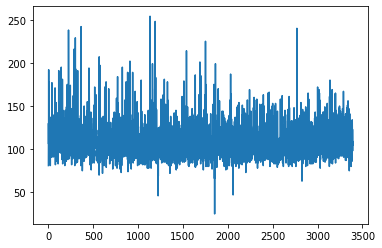

In [12]:
plt.plot(cluster_features.runtime.values)

On choisit de ne retenir que les films d'une durée comprise entre 40 minutes et 4 heures.

In [13]:
def clean_runtime(dfm, inf=40, sup=240):
    dfm = dfm[dfm.runtime >= inf]
    dfm = dfm[dfm.runtime <= sup]
    return dfm

In [14]:
cluster_features = clean_runtime(cluster_features)

On regarde la proportion de films pour lesquels certains champs n'ont pas été renseignés.

In [15]:
print("Nombre de films retenus dans cluster_features : ", len(cluster_features))
print("Parmi ces films :")
print(len(cluster_features[cluster_features.genres == "[]"]), "n'ont pas de genres")
print(len(cluster_features[cluster_features.keywords == "[]"]), "n'ont pas de keywords")
print(len(cluster_features[cluster_features.production_countries == "[]"]), "n'ont pas de production_countries")
print(len(cluster_features[cluster_features.crew == "[]"]), "n'ont pas de crew")

Nombre de films retenus dans cluster_features :  3390
Parmi ces films :
1 n'ont pas de genres
110 n'ont pas de keywords
24 n'ont pas de production_countries
0 n'ont pas de crew


Il s'agit d'une petite proportion, on peut donc retirer ces films problématiques.

In [16]:
def drop_missing_values(dfm):
    dfm = dfm[dfm.genres != "[]"]
    dfm = dfm[dfm.keywords != "[]"]
    dfm = dfm[dfm.production_countries != "[]"]
    return dfm

In [17]:
cluster_features = drop_missing_values(cluster_features)

In [18]:
print("Nombre de films dans cluster_features : ", len(cluster_features))

Nombre de films dans cluster_features :  3265


On peut maintenant se concentrer sur le traitement des données de chacune des colonnes. Il faut les simplifier au maximum pour rendre possible la comparaison de films basée sur ces attributs.

In [19]:
def vectorize_genres(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'genres'.
    It turns the column genres from a string that contains a dictionnary into an int list of genres id.'''
    
    def genres_to_id(gen):
        if isinstance(gen, str):
            pattern = re.compile(r"'id': [0-9]*")
            return np.array([int(w[6:]) for w in pattern.findall(gen)])
        return gen
    
    dfm.genres = dfm.genres.apply(genres_to_id)

In [20]:
vectorize_genres(cluster_features)

In [21]:
def vectorize_keywords(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'keywords'.
    It turns the column keywords from a string that contains a dictionnary into an int list of keywords id.'''
    
    def keywords_to_id(kw):
        if isinstance(kw, str):
            pattern = re.compile(r"'id': [0-9]*")
            return np.array([int(w[6:]) for w in pattern.findall(kw)])
        return kw
    
    dfm.keywords = dfm.keywords.apply(keywords_to_id)

In [22]:
vectorize_keywords(cluster_features)

In [23]:
def find_director(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'director'.
    It turns the column director from a string that contains a dictionnary into a string containing the director's name.'''
    
    def crew_to_director(crew):
        if '\"Director\"' in crew:
            start = crew.find('\"Director\"')+21
            new = crew[start:]
            end = new.find("\"")
            director = new[:end]
            return director
        return "director missing"
    
    dfm.director = dfm.director.apply(crew_to_director)
    dfm = dfm[dfm.director != "director missing"]

In [24]:
cluster_features = cluster_features.rename(columns={'crew' : 'director'})
find_director(cluster_features)

In [25]:
def simplify_date(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'release_date'.
    It turns the column release_date from a string date into an int being the year the film was released.'''
    
    def date_to_int(date):
        if isinstance(date, str):
            return int(date[:4])
        return date
    
    dfm.release_date = dfm.release_date.apply(date_to_int)

In [26]:
simplify_date(cluster_features)

In [27]:
def simplify_countries(dfm):
    
    '''This function takes a DataFrame dfm that must contain a column 'production_countries'.
    It turns the column production_countries from a string that contains a dictionnary into an int list of keywords id.'''
    
    def simplify(country):
        if isinstance(country, str):
            pattern = re.compile(r"'iso_3166_1': ...")
            return [w[15:] for w in pattern.findall(country)]
        return country
    
    dfm.production_countries = dfm.production_countries.apply(simplify)

In [28]:
simplify_countries(cluster_features)

In [29]:
cluster_features.head()

,title,genres,keywords,director,release_date,production_countries,original_language,runtime
movieId,,,,,,,,
1,Toy Story,"[16, 35, 10751]","[931, 4290, 5202, 6054, 9713, 9823, 165503, 17...",John Lasseter,1995,[US],en,81.0
10,GoldenEye,"[12, 28, 53]","[701, 769, 1308, 2812, 3268, 3272, 3278, 3376,...",Martin Campbell,1995,"[GB, US]",en,130.0
11,The American President,"[35, 18, 10749]","[833, 840, 1605, 33476, 211505]",Rob Reiner,1995,[US],en,106.0
14,Nixon,"[36, 18]","[840, 2946, 4240, 5565, 6086, 6165]",Oliver Stone,1995,[US],en,192.0
15,Cutthroat Island,"[28, 12]","[911, 1454, 1969, 3799, 5470, 12988]",Renny Harlin,1995,"[FR, DE, IT, US]",en,119.0


### Définition d'une distance sur les films

On va réaliser plus bas un hierarchical agglomerative clustering. Le principe est simple : on commence avec n clusters de 1 film, puis on fusionne à chaque itération les 2 clusters les plus proches, jusqu'à n'avoir plus d'un seul cluster contenant tous les films. Cela requiert une distance sur les films. C'est ce qu'on va construire ici. La tâche n'est pas simple : chaque film a été réduit à 7 attributs, et il faut aggréger ces 7 attributs pour déterminer à quel point 2 films sont similaires. On peut choisir d'accorder un poids différent à chacun des critères en fonction de leur importance.

In [30]:
# On définit ici des variables globales qui seront utilisées plus loin dans la fonction movie_distance
MAX_YEAR_DIFFERENCE = max(cluster_features.release_date) - min(cluster_features.release_date)
MAX_RUNTIME_DIFFERENCE = max(cluster_features.runtime) - min(cluster_features.runtime)

La fonction movie_distance calcule une distance entre 2 films. Plus cette valeur est proches de 0 et plus les films sont similaires. Plus la valeur est grande et plus ils sont différents. IMPORTANT : la built-in magic command %lprun nous a permis d'analyser la répartition du temps d'exécution lors du clustering sur les données. 99% du temps de calcul réside dans cette fonction de distance. Ce qui est le plus coûteux en temps est l'accès aux attributs des films. On les a donc réduit au strict minimum. De plus, on ne créé pas de vecteur à 7 coefficients qui stockerait la similitude entre les 2 films pour chaque critère. A la place, on additionne directement le carré de ces valeurs dans une variable de somme, puis on renvoit la racine carrée de cette variable. On utilise la norme 2 en la calculant à la main pour accélérer les calculs.

In [32]:
def movie_distance(m1, m2, w_gen=4, w_key=2, w_dir=2, w_rel=2, w_pro=3, w_ori=2, w_run=1):
    
    '''This function computes the distance between 2 movies m1 and m2 given some weight parameters.'''
    
    sum_vect = 0 # avoiding to store a vector just to compute his norm afterwards
    
    # SIMILARITIES IN GENRES
    g1 = m1.genres
    g2 = m2.genres
    gen = np.append(g1, g2)
    sum_vect += w_gen * (1 - (len(gen) - len(np.unique(gen))) / min(len(g1), len(g2))) ** 2
    
    # SIMILARITIES IN KEYWORDS
    kw1 = m1.keywords
    kw2 = m2.keywords
    kw = np.append(kw1, kw2)
    # Having one keyword in common is sufficient to make 2 films similar for this criterion
    # This choice was made because most films have many keywords
    if len(kw) == len(np.unique(kw)):
        sum_vect += w_key * 1 # ** 2
    
    # SIMILARITIES FOR THE DIRECTOR
    # 0 if it's the same director, else 1
    if m1.director != m2.director:
        sum_vect += w_dir * 1 # ** 2
    
    # SIMILARITIES FOR THE RELEASE DATE
    # the normalized difference between the 2 releade dates
    sum_vect += w_rel * (abs(m1.release_date - m2.release_date) / MAX_YEAR_DIFFERENCE) ** 2
    
    # SIMILARITIES IN PRODUCTION COUNTRIES
    pc = []
    pc1 = m1.production_countries
    pc.extend(pc1)
    pc2 = m2.production_countries
    pc.extend(pc2)
    pc_dist = 1 - (len(pc) - len(np.unique(pc))) / min(len(pc1), len(pc2))
    # As it is rare, we set that 2 films which are not from the US have something in common
    if 'US' not in pc1 and 'US' not in pc2 and pc_dist > 0.5:
        sum_vect += w_pro * 0.5 ** 2
    else:
        sum_vect += w_pro * pc_dist ** 2
    
    # SIMILARITIES FOR THE LANGUAGE
    lang1 = m1.original_language
    lang2 = m2.original_language
    if lang1 != lang2 :
        # As well, 2 films whose original language is not english have something in common
        if lang1 != 'en' and lang2 != 'en':
            sum_vect += w_ori * 0.5 ** 2
        else:
            sum_vect += w_ori * 1 ** 2
    
    # SIMILARITIES FOR THE RUNTIME
    # the normalized difference between the 2 runtimes
    sum_vect += w_run * (abs(m1.runtime - m2.runtime) / MAX_RUNTIME_DIFFERENCE) ** 2
    
    return np.sqrt(sum_vect)

Maintenant qu'on dispose d'une distance entre les films, on doit calculer la matrice de distance entre les films. Pour cela, on va utiliser un DataFrame avec en index et columns les id des movies (en string pour éviter toute confusion avec loc et iloc). On initilise un DataFrame vide avec les bonnes dimensions et les bons index / columns. On le remplit ensuite en faisant appel à la fonction movie_distance pour chaque paire de films. Comme par la suite on veut chercher le coefficient minimum de cette matrice, on met la distance d'un film à lui même à 1000 - un nombre suffisemment grand pour qu'aucune autre valeur de distance ne l'approche avec les choix de poids qu'on a fait.

In [33]:
def compute_dist_matrix(clu_fea):
    
    '''This function computes the distance matrix between all the movies contained in clu_fea.
    The clu_fea DataFrame must have been cleaned before. Returns the distance matrix.'''
    
    movies_id = clu_fea.index
    dist_mat = pd.DataFrame(np.nan * len(clu_fea), index=movies_id, columns=movies_id)
    for i in range(len(clu_fea)):
        for j in range(i, len(clu_fea)):
            if i == j:
                dist_mat.iat[i, j] = 1000
            else:
                dist_mat.iat[i, j] = dist_mat.iat[j, i] = movie_distance(clu_fea.iloc[i], clu_fea.iloc[j])
    
    return dist_mat

<b>HIERARCHICAL AGGLOMERATIVE CLUSTERING </b> <br>
Dans ce type de méthode de clustering, on n'a pas besoin de préciser le nombre de clusters attendus. L'algorithme permet de construire un dendrogramme, et on obtient nos clusters en coupant le dendrogramme à une certaine hauteur. On va commencer par écrire une classe dendrogram. Un objet de cette classe contient plusieurs attributs :
<li>Un champ leaf - valant None pour les noeuds dans l'arbre et contenant l'id d'un film (int) pour les feuilles </li>
<li>Un champ leaf_nb - un int indiquant pour chaque noeud le nombre de feuilles (et donc de films) de l'abre issu de ce noeud </li>
<li>Un champ father - une référence vers le père du noeud </li>
<li>Un champ left et un champ right - une référence vers le fils gauche (resp. fils droit) du noeud </li>
<li>Un champ height - un float indiquant la hauteur du noeud. Attention ! Il ne s'agit pas de la notion classique de hauteur d'un noeud dans un arbre binaire. <br>Il s'agit ici de la hauteur de fusion entre les 2 groupes de films (fils gauche et fils droit). Plus elle est élevée et plus ces 2 groupes de films sont différents </li>
<li>Un champ distance_to_father - un float indiquant la longueur de l'arête reliant le noeud à son père </li>

In [73]:
class dendrogram:
    
    def __init__(self, leaf=None):
        
        '''This is the dendrogram class constructor. It takes only one optional argument, which is leaf if the user
        wants to build a leaf containing a movie id. Otherwise it is a node and the leaf attribute is set to None.
        The other attributes are set to 0 or None for now, and should be modified by setters later on.'''
        
        self.leaf = leaf
        self.leaf_nb = 1
        self.father = None
        self.left = None
        self.right = None
        self.height = 0
        self.distance_to_father = 0
    
    def set_leaf_nb(self):
        
        '''This method is a setter for the leaf_nb attribute. It requires the left and right sons, as the total number
        of leaves of the node is the sum of its left and right leaf_nb attributes. If called on a leaf, leaf_nb should
        equal 1 due to the constructor, and set_leaf_nb set leaf_nb to 1 as well. This methode should always be called
        after creating a node that is not a leaf.'''
        
        total_leaf_nb = 0
        if self.left is not None:
            total_leaf_nb += self.left.leaf_nb
        if self.right is not None:
            total_leaf_nb += self.right.leaf_nb
        self.leaf_nb = max(1, total_leaf_nb)
    
    def set_height(self, height):
        
        '''This method is a setter for the height attribute. The height is given as a parameter. This method also sets
        the distance_to_father attribute of the node's left and right sons. If called on a leaf, this method does nothing.
        This methode should always be called after creating a node that is not a leaf.'''
        
        if self.left is None or self.right is None:
            return
        self.height = height
        self.left.distance_to_father = height - self.left.height
        self.right.distance_to_father = height - self.right.height
    
    def get_id_list(self):
        
        '''This method returns a list of all the id contained in the leafs of the node.It uses a prefix run.'''
        
        id_list = []
        def prefix(node):
            if node.leaf is not None:
                id_list.append(node.leaf)
            else:
                prefix(node.right)
                prefix(node.left)
        prefix(self)
        
        return id_list
    
    def get_root(self):
        
        '''This method returns the root of the tree to which the node belongs. The main goal of this method is
        to start from a leaf and find the root of the dendrogram, which is the leaf's cluster at a step k.'''
        
        tmp = self
        while tmp.father is not None: tmp = tmp.father
        return tmp
    
    def cut_at_threshold(self, threshold):
        
        '''This method provides a cut of the dendrogram at a height given by parameter threshold. It returns a list
        of dendrogram objects. Each element of the list can be seen as the root of a dendrogram, i.e. a cluster.'''
        
        assert threshold >= 0
        assert threshold <= self.height
        node_list = []
        def step(node, t):
            if node.height == 0:
                node_list.append([node])
            else:
                if node.left.height <= t:
                    node_list.append(node.left)
                else:
                    step(node.left, t)
                if node.right.height <= t:
                    node_list.append(node.right)
                else:
                    step(node.right, t)
        step(self, threshold)
        
        return node_list
    
    def clusters_threshold_cut(self, threshold):
        
        '''This method uses cut_at_threshold in order to return a list of movies id list. Each element
        of the list is a cluster that directly contains the id of all movies that belong to the cluster.'''
        
        cluster_list = self.cut_at_threshold(threshold)
        return [node.get_id_list() for node in cluster_list]
    
    def find_best_cut(self):
        
        '''This method does dendrogram cuts at 200 different threshold and keeps the best cut. It returns a list of
        movies id list, i.e. the different clusters. Some changes had to be made to avoid getting too many clusters.
        This is due to the distance choice between movies. Some attributes such as director or keywords are almost
        all different for 2 movies, resulting in a high distance between most movies, even between 2 movies that are
        very similar regarding genres, language, release date, production countries and runtime. That is why the method
        imposes a maximum number of clusters, which depends on the size of the input. The upper bound is quite high so
        that it enables many clusters, and it avoids to have some situations with e.g. 100 movies and 43 clusters.'''
        
        max_clu_nb = self.leaf_nb / np.sqrt(self.leaf_nb)
        threshold_list = np.linspace(0.01, self.height, 200)
        def step(t):
            nodes = self.cut_at_threshold(t)
            if len(nodes) > max_clu_nb:
                return 0
            return sum([n.distance_to_father for n in nodes]) / len(nodes)
        score = [step(t) for t in threshold_list]
        best_threshold_index = np.argmax(score)
        best_threshold = threshold_list[best_threshold_index]
        
        return self.clusters_threshold_cut(best_threshold)
    
    def get_n_clusters(self, n):
        
        '''This method provides a cut on the dendrogram that gives a number n of clusters, chosen in parameter.
        The different clusters are obtained by cutting at a threshold that leads to n clusters.
        It uses dichotomy in order to be efficient. It tries a cut at mid-height, check the number of
        clusters obtained and then decides to stop, cut at a higher height or cut at a lower height.'''
        
        assert n >= 1
        assert n <= self.leaf_nb
        # dichotomy
        xmin, xmax, xmid = 0, self.height, self.height / 2
        nodes = self.cut_at_threshold(xmid)
        while len(nodes) != n:
            if len(nodes) < n: 
                xmax, xmid = xmid, (xmid + xmin) / 2
            else:
                xmin, xmid = xmid, (xmid + xmax) / 2
            nodes = self.cut_at_threshold(xmid)
            # if the loop does not end - extremely unlickely but not impossible if 2 nodes
            # have the same height - it calls another cut function that returns n clusters
            if xmax - xmin < 1e-5:
                return self.get_n_clusters_perso(n)[0]
        
        return [n.get_id_list() for n in nodes]
        
    def get_n_clusters_perso(self, n):
        
        '''This method provides a cut on the dendrogram that gives a number n of clusters, chosen in parameter.
        It is called get_n_clusters_perso because I imaginated it alone and I don't think it exists elsewhere.
        The goal of this method is to solve the following problem : most of the time, cutting a dendrogram at
        a given height leads to a certain number of clusters. Among these clusters, some can be very small, there
        are even clusters with one element. So, instead of cutting at a threshold, the idea of this method is the
        following : it starts at the root and must provide n clusters, e.g. let's take n=10. If the left son's leaf
        number is greater than the right son's one, then the left son must provide let's say n=7 clusters, while the
        right son must provide n=3 clusters. Finally if the right son's have a very small number of leaves compared
        to the left son's one, then the left son must provide n=10 clusters and the leaves of the right son are added
        to a list of outliers. At the end of the process, there will be 10 clusters quite well balanced and one list
        of outliers, which can form a special cluster of, let's say, unclassifiable movies.'''
        
        if n <= 0 or n > self.leaf_nb:
            print("Bad choice for n : too big or <= 0")
            return
        cluster_list = []
        outliers = []
        error = []
        def step(node, n):
            if n == 1:
                cluster_list.append(node.get_id_list())
            elif node.left is None or node.right is None:
                error.append(True)
            else:
                prop_left = node.left.leaf_nb / node.leaf_nb
                prop_right = node.right.leaf_nb / node.leaf_nb
                # a node is considered an outlier if his leaf number
                # is less than 15% of his father's leaf number
                if prop_left < 0.15:
                    outliers.extend(node.left.get_id_list())
                    step(node.right, n)
                elif prop_right < 0.15:
                    outliers.extend(node.right.get_id_list())
                    step(node.left, n)
                else:
                    n_left = max(1, round(n * prop_left))
                    if n_left == n:
                        n_left -= 1
                    n_right = n - n_left
                    step(node.left, n_left)
                    step(node.right, n_right)
        step(self, n)
        if error:
            print("n too big")
        else:
            return cluster_list, outliers

On peut désormais écrire une classe pour implémenter le Hierarchical Agglomerative Clustering. Un objet de cette classe contiendra les attributs suivants :<br>
<li>Un champ dendrogram_root - une référence vers la racine du dendrogramme</li>
<li>Un champ cluster_id_list - une liste de listes de movies id, i.e. la liste des clusters</li>
<li>Un champ outliers - une liste de movies id, existant uniquement si on choisi la méthode perso</li>
<li>Un champ cluster_features - le DataFrame des films nettoyé sur lequel on apprend </li>

In [84]:
class hierarchical_cluster:
    
    def __init__(self):
        
        '''This is the hierarchical_cluster class constructor. It takes no arguments, all it does is to
        build an object. The 4 attributes will be initialized later on, when training the model.'''
        
        self.dendrogram_root = None
        self.cluster_id_list = None
        self.outliers = None
        self.cluster_features = None
    
    def set_cluster_features(self, dfm):
        
        '''This method is a setter for the attribute cluster_features. It takes one parameter, dfm, which is
        a DataFrame that contains all the information about movies. The method cleans the DataFrame and keeps
        only the attributes that are relevant for the movie clustering.'''
        
        # selection des attributs qui nous interessent pour le clustering
        clu_fea = dfm[['genres','keywords','crew','release_date','production_countries','original_language','runtime']]
        clu_fea = clu_fea.dropna()
        # on met en index les id des movies
        clu_fea.index = dfm.movieId.apply(lambda x: str(x))
        # nettoyage du dataframe
        clu_fea = clean_runtime(clu_fea)
        clu_fea = drop_missing_values(clu_fea)
        vectorize_keywords(clu_fea)
        vectorize_genres(clu_fea)
        clu_fea = clu_fea.rename(columns={'crew' : 'director'})
        find_director(clu_fea)
        simplify_date(clu_fea)
        simplify_countries(clu_fea)
        self.cluster_features = clu_fea
    
    def agglomerative_cluster(self, dist_mat):
        
        '''This method builds a dendrogram based on the distance matrix given in parameters. It returns
        its root. Important things to know about this function : 1) In order to avoid redundancy and to make
        the computations faster, it reduces the matrix size at each step by dropping a row and a colums.
        At the end, the matrix has 1x1 shape, so if one wants to store the matrix and keep it unchanged,
        he must call this method with a copy. 2) A choice which has a huge impact on the dendrogram was made
        here. In the algorithm, the 2 closest clusters are merged into a bigger one at each step. But there are
        several ways to measure the distance between clusters. It can be the distance between the centroids, the
        average distance, the minimal or maximal distance bewteen 2 points from different clusters. We chose this
        last option. It avoids to have many unbalanced branches, especially at levels close to the root.'''
        
        assert self.cluster_features is not None
        clu_fea = self.cluster_features
        clu_fea["dendrogram"] = clu_fea.index
        clu_fea.dendrogram = clu_fea.dendrogram.apply(lambda x: dendrogram(leaf=int(x)))
        size_mat = len(clu_fea)
        for _ in range(1, size_mat):
            # localisation de la plus petite distance dans la matrice
            index_str1, index_str2 = dist_mat.stack().idxmin()
            height = dist_mat.loc[index_str1, index_str2]
            mov1 = clu_fea.loc[index_str1]
            mov2 = clu_fea.loc[index_str2]
            tmp1 = mov1.dendrogram
            tmp2 = mov2.dendrogram
            # acces a la racine du cluster de mov1 et de celui de mov2
            while tmp1.father is not None: tmp1 = tmp1.father
            while tmp2.father is not None: tmp2 = tmp2.father
            # creation de la racine du nouvel arbre, fusion des 2 clusters
            tmp3 = dendrogram()
            tmp3.left = tmp1
            tmp3.right = tmp2
            tmp1.father = tmp3
            tmp2.father = tmp3
            tmp3.set_leaf_nb()
            tmp3.set_height(height)
            # actualisation de la matrice de distance
            new_d = np.maximum(dist_mat.loc[index_str1, :], dist_mat.loc[index_str2, :])
            dist_mat.loc[index_str1, :] = dist_mat.loc[:, index_str1] = new_d
            # suppression d'une des 2 lignes et colonnes qui font maintenant doublons
            dist_mat = dist_mat.drop(index_str2, axis=0)
            dist_mat = dist_mat.drop(index_str2, axis=1)
        
        return clu_fea.iloc[0].dendrogram.get_root()
    
    def train(self, dfm_cluster):
        
        '''This method coordinates the cluster construction. Firstly it cleans the DataFrame by calling the
        set_cluster_features method. Then it calls the function that computes the distance matrix. Finally
        it calls the agglomerative_cluster method in order to build the dendrogram.'''
        
        self.set_cluster_features(dfm_cluster)
        dist_mat = compute_dist_matrix(self.cluster_features)
        self.dendrogram_root = self.agglomerative_cluster(dist_mat)
    
    def set_n_clusters(self, n):
        
        '''This method cuts the dendrogram at a height that forms n different clusters.'''
        
        if self.dendrogram_root is None:
            print("Erreur, vous devez d'abord construire le dendrogram avec la methode train.")
        else:
            self.outliers = None
            self.cluster_id_list = self.dendrogram_root.get_n_clusters(n)
    
    def set_best_n_clusters(self):
        
        '''This method cuts the dendrogram at a height that maximizes the distance_to_father attributes
        of the cluster roots, on the condition that it doesn't create too many clusters.'''
        
        if self.dendrogram_root is None:
            print("Erreur, vous devez d'abord construire le dendrogram avec la methode train.")
        else:
            self.cluster_id_list = self.dendrogram_root.find_best_cut()
    
    def set_n_clusters_perso(self, n):
        
        '''This method cuts the dendrogram at different heights depending on the branch, so that if forms
        n clusters quite well balanced. It does not take the nodes height in consideration.'''
        
        if self.dendrogram_root is None:
            print("Erreur, vous devez d'abord construire le dendrogram avec la methode train.")
        else:
            self.cluster_id_list, self.outliers = self.dendrogram_root.get_n_clusters_perso(n)
    
    def get_cluster(self, pos, movies=None):
        
        '''This method returns a DataFrame that contains the movies from cluster number pos (first pos is 1).
        It uses the self.cluster_features attribute if the argument movies is not precised.'''
        
        if movies is None:
            movies = self.cluster_features
        if pos <= 0:
            print("Erreur, l'argument doit etre >= 1")
            return
        if pos > len(self.cluster_id_list):
            print("Erreur, il y a seulement ", len(self.cluster_id_list), " clusters.")
            return
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        df = pd.DataFrame([])
        if 'movieId' in movies.columns:
            for i in self.cluster_id_list[pos - 1]:
                df = df.append(movies[movies.movieId == int(i)])
        else:
            for i in self.cluster_id_list[pos - 1]:
                df = df.append(movies.loc[str(i)])
        return df
    
    def get_outliers(self, movies=None):
        
        '''This method returns a DataFrame that contains all the outliers movies. It exists only if the perso
        method is used when setting a number of clusters. Otherwise it returns an empty DataFrame.'''
        
        df = pd.DataFrame([])
        if self.outliers is None:
            return df
        if movies is None:
            movies = self.cluster_features
        if 'movieId' in movies.columns:
            for i in outliers:
                df = df.append(movies[movies.movieId == int(i)])
        else:
            for i in outliers:
                df = df.append(movies.loc[str(i)])
        return df
    
    def get_clusters_size(self):
        
        '''This method returns a list containing the size of the clusters,
        i.e. the number of movies for each cluster.'''
        
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        l = []
        for id_list in self.cluster_id_list:
            l.append(len(id_list))
        return l
    
    def find_closest_cluster(self, movie):
        
        '''This method finds the closest cluster for a movie given in parameter. The closest cluster is the
        cluster that contains the movie that is the closest to the argument.'''
        
        if self.cluster_id_list is None:
            print("Erreur, vous devez d'abord choisir un nombre de clusters avec la methode set_n_clusters.")
            return
        min_list = []
        for cluster in self.cluster_id_list:
            min_dist = np.min([movie_distance(movie, self.cluster_features.loc[str(m)]) for m in cluster])
            min_list.append(min_dist)
        index_closest_cluser = np.argmin(min_list)
        
        return self.cluster_id_list[index_closest_cluser]

Test sur un échantillon de taille 10

In [76]:
cluster_10 = hierarchical_cluster()
test_10 = dfm_cluster.sample(10)

In [79]:
%time cluster_10.train(test_10)

Wall time: 58.8 ms


In [80]:
cluster_10.set_n_clusters(3)

In [81]:
cluster_10.get_cluster(1, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
1704,Gus Van Sant,[18],"[1480, 1680, 1992, 2462, 2463, 3734, 6009, 625...",en,"[CA, US]",1997.0,126.0,Good Will Hunting
5815,Don Michael Paul,"[80, 28, 53]","[836, 1568, 3859, 8627]",en,"[DE, US]",2002.0,98.0,Half Past Dead
7360,Zack Snyder,"[14, 27, 28]","[972, 1583, 1912, 1926, 2081, 2583, 2776, 3725...",en,[US],2004.0,101.0,Dawn of the Dead
69821,Perry Lang,"[28, 53]","[1293, 2041, 3070, 10183, 10787]",en,"[US, ES]",1994.0,103.0,Men of War
160563,David Yates,"[28, 12]","[409, 5650, 7347, 10787, 158130]",en,"[CA, GB, US]",2016.0,109.0,The Legend of Tarzan


In [82]:
cluster_10.get_cluster(2, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
3979,Steven Brill,"[35, 14, 10749]","[494, 1155, 15001, 167707]",en,[US],2000.0,90.0,Little Nicky
58839,George Clooney,"[35, 10749, 18]","[579, 1483, 1485, 1701, 3836, 5398, 6149, 6186...",en,"[DE, US]",2008.0,114.0,Leatherheads
69122,Todd Phillips,[35],"[3508, 4809, 8070, 11461, 11462, 11464, 11465,...",en,"[DE, US]",2009.0,100.0,The Hangover


In [83]:
cluster_10.get_cluster(3, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
1949,Fred Zinnemann,"[18, 36]","[392, 717, 1829, 2122, 4350, 4351, 4352, 4353,...",en,[GB],1966.0,120.0,A Man for All Seasons
3854,Max F\u00e4rberb\u00f6ck,"[18, 36, 10749]","[220, 2606, 3691, 9833, 10180, 34215]",de,[DE],1999.0,125.0,Aimee & Jaguar


In [43]:
cluster_10.set_n_clusters_perso(3)

In [44]:
cluster_10.get_cluster(1, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
6338,Steve Carr,"[35, 10751]","[271, 3836, 4590, 10103, 156052]",en,[US],2003.0,92.0,Daddy Day Care
5449,Steven Brill,"[35, 10749]","[3452, 6018, 8680, 9468, 9821, 10911, 12547, 1...",en,[US],2002.0,96.0,Mr. Deeds
20,Joseph Ruben,"[28, 35, 80]","[380, 1552, 14512, 155735, 156120]",en,[US],1995.0,103.0,Money Train


In [45]:
cluster_10.get_cluster(2, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
3969,Mimi Leder,"[18, 10749]","[161868, 166625, 170365, 170375, 170378, 17038...",en,[US],2000.0,122.0,Pay It Forward
2154,Kevin Rodney Sullivan,"[35, 18, 10749]","[577, 965, 3266, 6876, 11322]",en,[US],1998.0,124.0,How Stella Got Her Groove Back
4890,Bobby Farrelly,"[35, 10749]","[2064, 3258, 3363, 4539, 8663, 8664, 8665, 997...",en,[US],2001.0,114.0,Shallow Hal
48744,John Cameron Mitchell,"[10749, 18, 35]","[237, 242, 460, 463, 571, 572, 826, 1252, 1664...",en,[US],2006.0,101.0,Shortbus


In [46]:
cluster_10.get_cluster(3, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
8196,Russ Meyer,"[35, 18, 53]","[637, 3490, 4344]",en,[US],1970.0,109.0,Beyond the Valley of the Dolls


In [47]:
cluster_10.set_best_n_clusters()

In [48]:
cluster_10.get_cluster(1, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
8196,Russ Meyer,"[35, 18, 53]","[637, 3490, 4344]",en,[US],1970.0,109.0,Beyond the Valley of the Dolls
3969,Mimi Leder,"[18, 10749]","[161868, 166625, 170365, 170375, 170378, 17038...",en,[US],2000.0,122.0,Pay It Forward
2154,Kevin Rodney Sullivan,"[35, 18, 10749]","[577, 965, 3266, 6876, 11322]",en,[US],1998.0,124.0,How Stella Got Her Groove Back
4890,Bobby Farrelly,"[35, 10749]","[2064, 3258, 3363, 4539, 8663, 8664, 8665, 997...",en,[US],2001.0,114.0,Shallow Hal
48744,John Cameron Mitchell,"[10749, 18, 35]","[237, 242, 460, 463, 571, 572, 826, 1252, 1664...",en,[US],2006.0,101.0,Shortbus
6338,Steve Carr,"[35, 10751]","[271, 3836, 4590, 10103, 156052]",en,[US],2003.0,92.0,Daddy Day Care
5449,Steven Brill,"[35, 10749]","[3452, 6018, 8680, 9468, 9821, 10911, 12547, 1...",en,[US],2002.0,96.0,Mr. Deeds
20,Joseph Ruben,"[28, 35, 80]","[380, 1552, 14512, 155735, 156120]",en,[US],1995.0,103.0,Money Train


In [49]:
cluster_10.get_cluster(2, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
105954,J.C. Chandor,"[28, 12, 18]","[3342, 41599, 168683, 175316, 175668, 176052, ...",en,[US],2013.0,106.0,All Is Lost


In [50]:
cluster_10.get_cluster(3, cluster_features)

Erreur, il y a seulement  2  clusters.


In [51]:
cluster_10.get_cluster(4, cluster_features)

Erreur, il y a seulement  2  clusters.


In [52]:
cluster_10.get_cluster(5, cluster_features)

Erreur, il y a seulement  2  clusters.


Test sur un échantillon de taille 100

In [53]:
test_100 = dfm_cluster.sample(100)
cluster_100 = hierarchical_cluster()

In [55]:
%time cluster_100.train(test_100)

Wall time: 3.09 s


In [446]:
%lprun -f movie_distance cluster_100.train(test_100)

In [56]:
cluster_100.set_n_clusters(6)
cluster_100.get_clusters_size()

[72, 4, 12, 2, 3, 3]

In [57]:
cluster_100.set_n_clusters_perso(6)
print(len(cluster_100.outliers), " outliers")
cluster_100.get_clusters_size()

30  outliers


[18, 4, 12, 10, 11, 11]

In [58]:
cluster_100.set_best_n_clusters()
cluster_100.get_clusters_size()

[76, 12, 2, 3, 3]

In [59]:
cluster_100.get_cluster(1, cluster_features)

,director,genres,keywords,original_language,production_countries,release_date,runtime,title
1282,David Hand,"[16, 10751, 10402]","[3537, 5783, 190719]",en,[US],1940.0,124.0,Fantasia
1093,Oliver Stone,"[18, 10402]","[458, 496, 572, 578, 2483, 3298, 3593, 3800, 4...",en,[US],1991.0,140.0,The Doors
914,George Cukor,"[18, 10751, 10402, 10749]","[4344, 4375, 4485, 10786, 11411, 11707, 14514,...",en,[US],1964.0,170.0,My Fair Lady
7080,Lloyd Bacon,"[10402, 35, 10749]","[276, 4344, 6415, 14530, 15142, 33926, 41316, ...",en,[US],1933.0,89.0,42nd Street
109374,Wes Anderson,"[35, 18]","[612, 5918, 11159, 12371, 14604, 172772, 18104...",en,"[GB, US, DE]",2014.0,99.0,The Grand Budapest Hotel
...,...,...,...,...,...,...,...,...
7255,Robert Luketic,"[35, 10749]","[6562, 9799, 10556, 162262]",en,[US],2004.0,95.0,Win a Date with Tad Hamilton!
6212,Adam Shankman,[35],"[378, 1594, 3848, 10685, 10909]",en,[US],2003.0,105.0,Bringing Down the House
6006,Shawn Levy,[35],"[110, 254, 378, 657, 1295, 2587, 2676, 3098, 3...",en,"[DE, US]",2003.0,95.0,Just Married
69604,Woody Allen,"[35, 10749]","[699, 708, 965, 2487, 5950, 6038, 8778, 9622, ...",en,"[FR, US]",2009.0,92.0,Whatever Works


Données complètes : 50 minutes pour run

In [333]:
cluster = hierarchical_cluster()

In [334]:
%time cluster.train(dfm_cluster)

Wall time: 51min 16s


In [406]:
cluster.set_n_clusters(10)
cluster.get_clusters_size()

[690, 393, 26, 467, 189, 185, 116, 400, 79, 724]

In [341]:
cluster.set_n_clusters_perso(10)
print(len(cluster_100.outliers), " outliers")
cluster.get_clusters_size()

8  outliers


[469, 198, 419, 321, 118, 374, 116, 400, 580, 144]

In [347]:
cluster.set_best_n_clusters()
cluster.get_clusters_size()

[690,
 362,
 31,
 22,
 4,
 169,
 21,
 7,
 27,
 69,
 20,
 6,
 2,
 118,
 28,
 119,
 44,
 26,
 185,
 81,
 10,
 18,
 7,
 20,
 18,
 60,
 114,
 38,
 60,
 19,
 3,
 17,
 9,
 4,
 4,
 7,
 4,
 11,
 6,
 6,
 79,
 580,
 144]

## Model-based recommendation system

La matrice des notes user-item $R$ est partiellement vide. Ainsi réduire les dimensions de la matrice pourrait améliorer la complexité de nos algorithmes. Une méthode que nous pourrions avoir envie d'utiliser est la décomposision en valeurs singulières : $R = U_{svd} \Sigma V_{svd}$. Cependant cette méthode ne s'applique pas ici étant donné que $R$ n'est pas complète et qu'on a besoin de réaliser des calculs algébriques avec $R$ pour trouver la décomposition.

On considère donc un modèle dans lequel il existe des attributs décrivants les films et les préférences des utilisateurs. La matrice $R$ peut alors être factorisée en produit de deux matrices $U$ et $V$ représentant respectivement les utilisateurs et les items :

$$
R \approx U \times V^T
$$

avec $R \in \mathbb{R}^{n \times m}$ la matrice des notes user-item, $U \in \mathbb{R}^{n \times \ell}$ la matrice des users, $V \in \mathbb{R}^{m \times \ell}$ la matrice des items et $\ell$ le nombre d'attributs. Pour faire un rapprochement avec la SVD, on peut considerer que $U = U_{svd} \Sigma^{1/2}$ et $V = \Sigma^{1/2} V_{svd}$. On note $U_i$ les lignes de $U$ et $V_j$ les lignes de $V$ :
$
U = \left[ \begin{array}{c} U_1 \\ \vdots \\ U_n \end{array} \right]
$ et 
$
V = \left[ \begin{array}{c} V_1 \\ \vdots \\ V_m \end{array} \right]
$
avec $U_i^T, V_j^T \in \mathbb{R^\ell}$.

Dans ce modèle, chaque note $R_{ij}$ associée à un couple user-item $(i, j)$ est le résultat du produit scalaire entre la ligne associée au user $i$ dans $U$ et la ligne associée au item $j$ dans $V$ : $R_{ij} = U_i \cdot V_j^T$. Une fois les matrices $U$ et $V$ apprises, pour prédire une note il suffira de faire le produit scalaire entre les lignes associées.

Trouver $U$ et $I$ revient à minimiser l'erreur entre la note prédite $U_i \cdot V_j^T$ et la véritable note $R_{ij}$. Il s'agit du problème de minimisation suivant, avec $E = \{(i, j) \mbox{ | } R_{ij} \mbox{ connue}\}$ :

$$
(U, V) = argmin_{(U, V)} \sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2
$$

qui est équivalent à:

$$
(U, V) = argmin_{(U, V)} \frac{1}{2}\sum_{(i, j) \in E} [U_i \cdot V_j^T - R_{ij}]^2 + \lambda (\|U_i\|^2 + \|V_j\|^2)
$$

Le terme de droite est un terme régulateur, de paramètre $\lambda$ à ajuster, permettant de prévenir un overfitting.

Pour résoudre ce problème, nous allons utiliser une méthode de descente de gradient.


*Pour résoudre ce problème, on peut utiliser une méthode de descente de gradient. Nous allons ensuite optimiser cette méthode en utilisant d'abord des batch, puis en se réduisant à un problème de moindre carré en fixant alternativement les matrices $U$ et $V$.*

### Descente de gradient (à pas constant)

Dans notre [cours d'optimisation](https://www.ceremade.dauphine.fr/~gontier/enseignement.html) donné par David Gontier, nous avons étudié différentes méthodes de descente de gradient de complexité et d'optimalité différentes. Cependant il nous semble qu'utiliser une version simple à pas $\tau$ constant suffit. Il sera possible de régler cet hyper-paramètre par validation croisée. 

Notre fonction objective est la suivante :
$$
F(U, V) := \sum_{(i, j) \in E} \frac{1}{2}[U_i \cdot V_j^T - R_{ij}]^2 + \frac{\lambda}{2} (\|U_i\|^2 + \|V_j\|^2)
$$

Dans une descente de gradient classique, à chaque itération on met à jour $U$ et $V$ suivant la formule 
$
(U, V) = (U, V) - \tau \nabla F(U, V)
$. Cependant, dans notre cas nous n'allons pas mettre à jour toutes les lignes de $U$ et $V$ simultanément. En effet, puisque la somme dans $F$ ne se fait que sur les couples $(i, j)$ pour lesquels la note est connue, nous allons seulement mettre à jour le couple $(U_i, V_j)$ associé en itérant sur tous les couples $(i, j) \in E$. 

Pour une note $R_{ij}$, on a 
$
\frac{\partial F}{\partial U_i} = V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i
$
 et 
$
\frac{\partial F}{\partial V_j} = Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j
$
donc on peut mettre à jour les lignes $U_i$ et $V_j$ selon les formules 
$$
U_i = Ui - \tau [V_j^T (U_i \cdot V_j^T - R_{ij}) + \lambda U_i]\\
V_j = V_j - \tau [Ui (U_i \cdot V_j^T - R_{ij}) + \lambda V_j]
$$

In [ ]:
dfr = ratings.copy()
user_rank = dfr.userId.unique().tolist()
movie_rank = dfr.movieId.unique().tolist()
R = [ratings.loc[ratings['userId'] == user, ['rating']].to_numpy() for user in user_rank]

In [ ]:
R.head()

In [ ]:
n = len(R.userId.unique())
m = len(R.movieId.unique())
print('n:', n, 'm:', m)

In [ ]:
a = R.movieId.unique()
a.sort()
print(a)
R.userId.unique()[:100]

Il se peut que tous les entiers entre 1 et $n$ (ou $m$) ne soient pas utlisés par les id des users (ou des movies). Ceci est par exemple le cas lorsqu'on travaille avec un échantillon des données. Puisque nous aimerions utiliser des numpy array dans nos calculs, il va être nécessaire d'avoir la correspondant entre les id et les indices utilisés dans les numpy array (que nous allons appeler rang). Pour cela, utilisons simplement une liste contenant les id et dont l'indice dans la liste d'un id donné correspondra au rang. Pour trouver l'id à partir d'un rang il suffira de faire un simple extraction, pour trouver le rang à partir d'un id on utilisera la méthode `index()`.

In [ ]:
user_rank = R.userId.unique().tolist()
movie_rank = R.movieId.unique().tolist()

La matrice $R$ étant vide, nous n'allons pas utiliser de matrice pour la représenter et garderons la dataframe qui ne contient que les notes connues. Nous allons également avoir besoin d'écrire une fonction `get_rat()` qui permet d'accéder à la note d'un couple de rang dans la dataframe des notes. Nous utilisons également une fonction `known()` pour construire l'ensemble $E$.

# <span style="color:green"> Comparer si get_rat plus efficace avec R une dataframe ou R un numpy matrix </span>

In [ ]:
def get_rat(R, i, j):
    '''
    Retourne la note de rang (i, j) dans la dataframe R
    '''
    uid, mid = user_rank[i], movie_rank[j]
    return float(R.loc[(R['userId'] == uid) & (R['movieId'] == mid), 'rating'])

In [ ]:
def known(R):
    '''
    Retourne l'ensemble des indices (i, j) pour lesquels la note est connue dans R
    '''
    ids = set(R.loc[:, ['userId', 'movieId']].itertuples(index=False, name=None))
    E = set(map(lambda t : (user_rank.index(t[0]), movie_rank.index(t[1])), ids ))
    return E

Nous pouvons à présent écrire la fonction résolvant notre problème de minimisation. Remarquons qu'elle modifie les valeurs de $U$ et $V$ en place.

# <span style="color:green"> Condition d'arrêt de la descente : prends trop de temps à calculer </span>

In [ ]:
def compute_rmse(U, V, E):
    predicted = np.dot(U, V.T) # the predicted rating matrix
    
    rmse = 0
    nb_instances = 0
    for (i, j) in E :
        rmse += (predicted[i, j] - get_rat(R, i, j)) ** 2 
        nb_instances += 1
    return np.sqrt(rmse / nb_instances)

In [ ]:
def descenteGradient(U, V, tau, tol=1e-3, Niter=100, verbose=False):
    E = known(R)
    last_rmse = 0
    
    if verbose:
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        logging.info('nombre de couples : {}'.format(len(E)))

    for n in range(Niter):
        if verbose :
            logging.info("iteration: {}".format(n))
            logging.info('compute rmse')
        
        rmse = compute_rmse(U, V, E)
        if abs(rmse - last_rmse) < tol:
            return U, V
        last_rmse = rmse

        if verbose:
            logging.info('update U and V')
        
        n_couple = 0
        for (i, j) in E :
            if verbose and not n_couple % 10000:
                logging.info("couple number: {}".format(n_couple))
            n_couple += 1
    
            gradU = V[j].T * (np.dot(U[i], V[j].T) - get_rat(R, i, j)) + lamb * U[i]
            gradV = U[i] * (np.dot(U[i], V[j].T) - get_rat(R, i, j)) + lamb * V[j]
            U[i] = U[i] - tau * gradU
            V[j] = V[j] - tau * gradV
    print("Erreur, l’algorithme n’a pas convergé après", Niter ," itérations")
    return U, V

In [ ]:
# hyper-paramètres à tuned
ell = 10
tau = 1/10
lamb = 1/2
U, V = np.random.rand(n, ell), np.random.rand(m, ell)
print(U[:5, :5])
print(V[:5, :5])

In [ ]:
t1 = time()
descenteGradient(U, V, tau, verbose=True)
t2 = time()
print(t2-t1)

In [ ]:
t1 = time()
rmse = compute_rmse(U, V, known(R))
t2 = time()
print(t2-t1)
print(rmse)

In [ ]:
def predict_model(uid, mid):
    user = user_rank[uid]
    movie = movie_rank[mid]
    return np.dot(U[user], V[movie].T)

In [ ]:
user = 3
movie = 4

print(predict_model(user, movie))

### Cross-validation


## Linear model : content-based

On remarque que si $U$ ou $V$ est fixé, la fonction objective devient quadratique. Or nous connaissons des algorithmes efficaces pour minimiser des fonctions quadratiques. De plus, une matrice d'attributs des films peut être donnée puisqu'on connaît certaines informations sur les films.